# Notebook to prepare the Eigenstrat of D. Reich
Idea: Keep it as Code Sequence, so I can readily update in case data gets updated

### Overview of structure of this notebook

1. Download the Data
2. Test 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.colors as cls
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [1]:
# Download the Data
def download_eigenstrat():
    download_link = "https://reichdata.hms.harvard.edu/pub/datasets/amh_repo/curated_releases/V37/V37.2/SHARE/public.dir/v37.2.1240K.tar"
    file_name = os.path.basename(download_link)  # Get the File Name
    local_folder ="./Data/ReichLabEigenstrat/Raw/"
    download_path = os.path.join(local_folder, file_name) 

    if not os.path.exists(local_folder):
        print(f"Creating {local_folder}...")
        os.makedirs(local_folder)

    ### Run the Shell Download
    !wget -P $download_path $download_link 
    
def unpack_eigenstrat():
    ### Untar the file
    !tar -xf $download_path -C $local_folder
    !rm $download_path  # Delete the tar File

In [2]:
#download_eigenstrat()
#unpack_eigenstrat()

# Analyze the Reich Meta Data
Standalone

### Load and process meta data

In [7]:
### Load Metafile from D. Reich:
def load_eigenstrat_anno(path="./Data/ReichLabEigenstrat/Raw/v37.2.1240K.clean4.anno", anc_only=True):
    """Load annotated Eigenstrat (from D. Reich's group)"""
    df_anno = pd.read_csv(path, sep="\t", engine="python")
    coverage = pd.to_numeric(df_anno["Coverage"], errors='coerce')
    df_anno["coverage"]=coverage

    # Convert the Ages as well
    ages = df_anno["Average of 95.4% date range in calBP (defined as 1950 CE)  "]
    df_anno["ages"] = pd.to_numeric(ages, errors='coerce')  #

    ### Convert Longitude and Latitude
    lat = df_anno["Lat."]
    lon = df_anno["Long."]
    df_anno["lat"] = pd.to_numeric(lat, errors='coerce')
    df_anno["lon"] = pd.to_numeric(lon, errors='coerce')
    df_anno["iid"] = df_anno["Instance ID"]
    
    df_anc = df_anno[df_anno["ages"]>0]

    print(f"Loaded {len(df_anc)} / {len(df_anno)} ancient Indivdiuals.")
    print(f"Without Coverage: {np.sum(np.isnan(coverage))}")
    if anc_only:
        df_anno=df_anc
    return df_anno

In [47]:
df_anc = load_eigenstrat_anno()
len(df_anc)

Loaded 2106 / 5081 ancient Indivdiuals.
Without Coverage: 2581


2106

# Prepare new Meta-File with standardized columns
Run df_anc creation above, and then here save it

In [58]:
def produce_meta_csv(df_anc, save_path = "./Data/ReichLabEigenstrat/Raw/meta.csv"):
    """Produce a formatted meta .csv in my style, to streamline
    further processing (and use same machinery)"""
    ### Transfer the include_alt column
    asmts = df_anc["ASSESSMENT"]
    good = asmts.str.startswith("PASS") # the ones that pass
    bad = asmts.str.startswith("QUES")  # The ones that are "questionable" contamination
    
    assert(len(asmts)==np.sum(good) + np.sum(bad))

    include = np.zeros(len(asmts), dtype="int8")
    include[good]=1
    df_anc["ASSESSMENT"] = include # Save column

    df_save = df_anc[["iid", "lat", "lon", "ages", "Publication", "Group ID", "coverage", "SNPs hit on autosomes", "ASSESSMENT"]]
    df_save.columns =["iid", "lat", "lon", "age", "study", "clst", "mean_cov", "n_cov_snp", "include_alt"]  # Rename to standard columns
    if len(save_path)>0:
        df_save.to_csv(save_path, index=False)
        print(f"Saved {len(df_save)} rows to {save_path}")
    return df_save

In [59]:
df_anc = load_eigenstrat_anno()
df_save = produce_meta_csv(df_anc)

Loaded 2106 / 5081 ancient Indivdiuals.
Without Coverage: 2581
Saved 2106 rows to ./Data/ReichLabEigenstrat/Raw/meta.csv


In [16]:
meta_path = "./Data/Marcus2019_1240k/meta_rev_final.csv"
meta_df = pd.read_csv(meta_path)  # Load the Meta File
meta_df.columns

Index(['iid', 'label', 'lat', 'lon', 'x_contam', 'mt_contam', 'age', 'study',
       'clst_alt', 'period_alt', 'include_alt', 'clst', 'mean_cov', 'med_cov',
       'n_cov_snp_read', 'full_iid', 'n_cov_snp'],
      dtype='object')

### Histogram of ReichAll Ages

In [11]:
### Extract only the non-Moderns: 
age_okay = (df_anc["ages"]>0) & (df_anc["ages"]<20000)
np.sum(age_okay)

2065

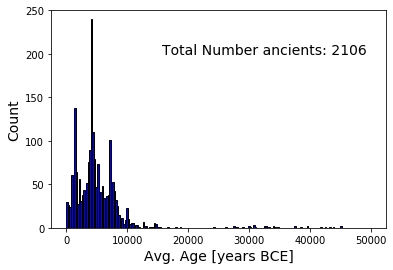

In [12]:
### Interesting Columns: 
#"SNPs hit on autosomes", "Coverage"
#Average of 95.4% date range in calBP (defined as 1950 CE)  
fs = 14
bins = np.linspace(0, 5e4, 200)

plt.figure(figsize=(6,4))
ax=plt.gca()
plt.hist(df_anc["ages"], color="blue", ec="k", bins=bins)
#ax.axvline(0.5, color="red", lw=2)
plt.ylim([0,250])
plt.xlabel("Avg. Age [years BCE]", fontsize=fs)
plt.ylabel("Count", fontsize=fs)
ax.text(x=0.33, y=0.8, 
        s=f"Total Number ancients: {len(df_anc)}", transform=ax.transAxes, fontsize=fs)
plt.show()

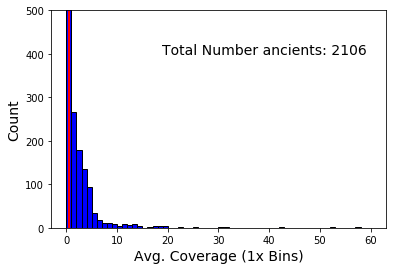

In [121]:
### Interesting Columns: 
#"SNPs hit on autosomes", "Coverage"
#Average of 95.4% date range in calBP (defined as 1950 CE)  
fs = 14
bins = np.linspace(0, 60, 61)

plt.figure(figsize=(6,4))
ax=plt.gca()
plt.hist(df_anc["coverage"], color="blue", ec="k", bins=bins)
ax.axvline(0.5, color="red", lw=2)
plt.ylim([0,500])
plt.xlabel("Avg. Coverage (1x Bins)", fontsize=fs)
plt.ylabel("Count", fontsize=fs)
ax.text(x=0.33, y=0.8, 
        s=f"Total Number ancients: {len(df_anc)}", transform=ax.transAxes, fontsize=fs)
plt.show()

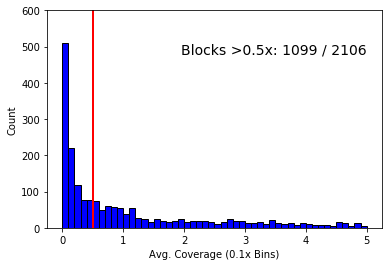

In [127]:
bins = np.linspace(0, 5, 51)
fs = 14
plt.figure(figsize=(6,4))
ax=plt.gca()
ax.axvline(0.5, color="red", lw=2)

plt.hist(df_anc["coverage"], color="blue", ec="k", bins=bins)
plt.ylim([0,600])
plt.xlabel("Avg. Coverage (0.1x Bins)")
plt.ylabel("Count")
covs = df_anc["coverage"]
ax.text(x=0.4, y=0.8, s=f"Blocks >0.5x: {np.sum(covs>0.5)} / {len(covs)}", 
        transform=ax.transAxes, fontsize=fs)
plt.show()

### Plot all ReichAll Samples on a world Map

In [200]:
df_plot = df_anc[df_anc["coverage"]>0.5]
len(df_plot)

1099

In [182]:
c_map = "viridis_r"
p_range= (0, 12000)
cmap0 = cm.get_cmap(c_map)
norm0 = plt.Normalize(p_range[0], vmax=p_range[1])  # Normalize to age BCE

normc = cls.Normalize(vmin = p_range[0]/1e3, vmax = p_range[1]/1e3) # For the Color Bar
colors = [cmap0(norm0(i)) for i in df_anc["ages"].values]

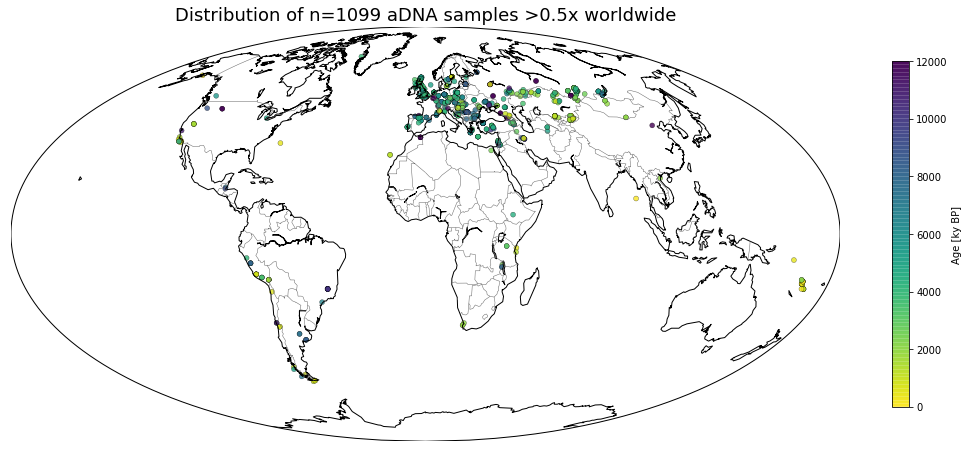

In [208]:
fs = 18

fig = plt.figure(figsize=(18,12))
ax=fig.add_axes([0.1,0.1,0.8,0.8])

#m = Basemap(projection='cyl',llcrnrlat=-60,urcrnrlat=85, 
#                llcrnrlon=-180,urcrnrlon=180,resolution='c')

m = Basemap(projection='moll', lat_0=0, lon_0=0)
#
m.drawcoastlines()
#m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,1], fontsize=8)
#m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1], rotation=45, fontsize=8)

#m.etopo(scale=0.5, alpha=0.4)  # if topological map
m.drawcoastlines(color='gray', zorder=0)
m.drawcountries(color="dimgray")
#m.drawstates()

plt.title(f"Distribution of n={len(df_plot)} aDNA samples >0.5x worldwide", fontsize=fs)

m.scatter(df_plot["lon"].values, df_plot["lat"].values, latlon=True, cmap=cmap0, norm=norm0,
          c=df_plot["ages"].values, alpha=0.8, s=25, edgecolors='k', linewidths=0.3)

plt.colorbar(label="Age [ky BP]", shrink=0.5)
fig.savefig("./figures_test/reich_eigenstrat_map.png", dpi=200, bbox_inches = 'tight', pad_inches = 0)
#plt.close(fig)

plt.show()

### Test Intersection with Sardina

In [24]:
meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
meta_df = pd.read_csv(meta_path)
df_anc_m = meta_df[:1057]   # 1098 is all ancients

In [25]:
df_merge = pd.merge(df_anc_m, df_anc[["iid","ages","coverage"]], on="iid")
print(f"Found {len(df_merge)} Samples in both datasets")

Found 846 Samples in both datasets


In [26]:
diff_age = df_merge["age"]-df_merge["ages"]
df_merge[np.abs(diff_age)>500]

,iid,label,lat,lon,x_contam,mt_contam,age,study,clst_alt,period_alt,include_alt,clst,mean_cov,med_cov,n_cov_snp_read,full_iid,n_cov_snp,ages,coverage
66,I5408,Iron_Gates_HG,44.517000,22.722000,NaN,NaN,7450.0,Mathieson et al. 2018,Iron_Gates,HG,1,Iron_Gates-HG,0.642716,0.0,506320.0,I5408,506320,8704.0,0.643000
186,I1955,Iran_recent,34.450000,48.116000,NaN,NaN,3407.5,Lazaridis et al. 2016,Iran,-9,0,Sar--9,3.957653,2.0,772189.0,I1955,772189,493.0,4.231000
329,I5118,Hungary_LCA,47.809892,20.889267,NaN,NaN,5150.0,Olalde et al. 2018,Hungary,LCA,1,Balkans-BA,1.590726,1.0,664598.0,I5118,664598,4550.0,1.631000
340,I7042,Hungary_BA,47.429954,19.051966,NaN,NaN,4300.0,Olalde et al. 2018,Hungary,BA,1,Balkans-BA,3.987566,1.0,757304.0,I7042,757304,6050.0,4.310566
341,I5116,Hungary_LCA,47.809892,20.889267,NaN,NaN,5150.0,Olalde et al. 2018,Hungary,LCA,1,Balkans-BA,0.013566,0.0,15313.0,I5116,15313,4550.0,0.014000
371,I4930,Beaker Sicily,37.734970,12.961900,NaN,NaN,4150.0,Olalde et al. 2018,Sicily,Bk,1,Sicily-Bk,0.034670,0.0,38719.0,I4930,38719,4721.0,0.035000
419,I7272,Corded_Ware_Czech,50.190000,14.158000,NaN,NaN,4500.0,Olalde et al. 2018,Czech,Cw,1,CE-EBA,3.436655,1.0,745897.0,I7272,745897,5450.0,3.646946
424,I7197,Czech_EBA,50.050415,14.366727,NaN,NaN,3900.0,Olalde et al. 2018,Czech,EBA,1,CE-LBA,2.665659,1.0,711986.0,I7197,711986,6450.0,2.767748
456,I5117,Hungary_LCA,47.809892,20.889267,NaN,NaN,5150.0,Olalde et al. 2018,Hungary,LCA,1,Balkans-BA,0.372487,0.0,322382.0,I5117,322382,4550.0,0.373000
739,I0211,EHG,61.650000,35.650000,NaN,NaN,7200.0,Lazaridis et al. 2016,EHG,HG,1,EHG-HG,0.132490,0.0,137173.0,I0211,137173,8280.0,0.136000


In [29]:
np.corrcoef(df_merge["mean_cov"].values, df_merge["coverage"].values)

array([[1.        , 0.98032728],
       [0.98032728, 1.        ]])

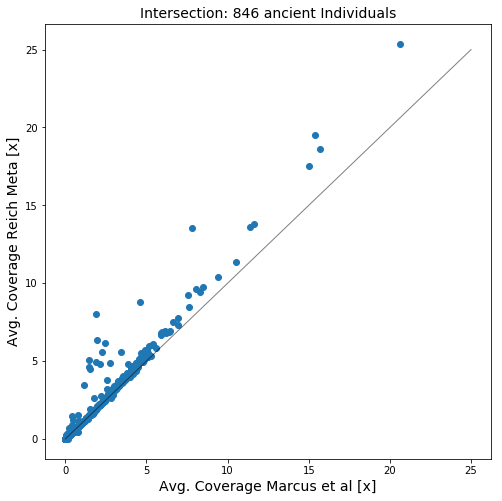

In [30]:
plt.figure(figsize=(8,8))
fs=14
plt.scatter(df_merge["mean_cov"], df_merge["coverage"])
plt.xlabel("Avg. Coverage Marcus et al [x]", fontsize=fs)
plt.ylabel("Avg. Coverage Reich Meta [x]", fontsize=fs)
plt.plot([0,25],[0,25], lw=1, alpha=0.5, c="k")
plt.title(f"Intersection: {len(df_merge)} ancient Individuals", fontsize=fs)
plt.show()

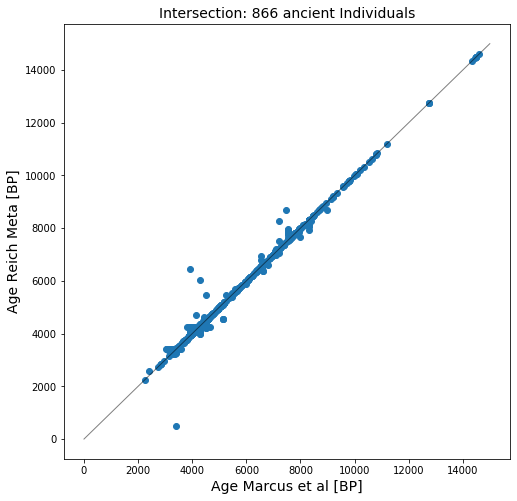

In [42]:
plt.figure(figsize=(8,8))
fs=14
plt.scatter(df_merge["age"], df_merge["ages"])
plt.xlabel("Age Marcus et al [BP]", fontsize=fs)
plt.ylabel("Age Reich Meta [BP]", fontsize=fs)
plt.plot([0,15000],[0,15000], lw=1, alpha=0.5, c="k")
plt.title(f"Intersection: {len(df_merge)} ancient Individuals", fontsize=fs)
plt.show()

In [7]:
np.sum(df_merge["mean_cov"]>0.5)

514

# Area 51
Test code here

In [4]:
download_link = "https://reichdata.hms.harvard.edu/pub/datasets/amh_repo/curated_releases/V37/V37.2/SHARE/public.dir/v37.2.1240K.tar"
os.path.basename(download_link)

'v37.2.1240K.tar'

In [8]:
file_name

'v37.2.1240K.tar'